# Load Data

In [1]:
import os
import sys

feat_dir = os.path.join('..', 'ML_Forex_Forecasting')
sys.path.append(feat_dir)

In [2]:
import pandas as pd
from generate_features import generate_features

In [3]:
usd_eur = pd.read_csv(os.path.join(feat_dir, "./USDEUR=X.csv"), parse_dates=['Date'])
eur_chf = pd.read_csv(os.path.join(feat_dir, "./EURCHF=X.csv"), parse_dates=['Date'])
eur_gbp = pd.read_csv(os.path.join(feat_dir, "./EURGBP=X.csv"), parse_dates=['Date'])
gbp_chf = pd.read_csv(os.path.join(feat_dir, "./GBPCHF=X.csv"), parse_dates=['Date'])
usd_chf = pd.read_csv(os.path.join(feat_dir, "./USDCHF=X.csv"), parse_dates=['Date'])
usd_gbp = pd.read_csv(os.path.join(feat_dir, "./USDGBP=X.csv"), parse_dates=['Date'])

In [4]:
data = usd_chf

In [5]:
feats = generate_features(data)
print(f"EUR/CHF Features shape: {feats.shape}")
display(feats.head())

EUR/CHF Features shape: (262, 28)


,Date,opt_sine_offset,opt_sine_amp,opt_sine_freq,opt_sine_phase,opt_fourier_offset,opt_fourier_cosamp,opt_fourier_cosfreq,opt_fourier_cosphase,opt_fourier_sinamp,...,ROC1,ROC5,ROC20,WILLIAMS14,RSI14,CMO9,DEMA9,TEMA9,STOCH14,Close
0,2023-11-04,0.904953,1.000000,1.000124,0.000366,0.905610,0.215978,1.072017,-4.397565,-0.215485,...,84.982082,34.598417,151.006874,-4255.357016,45.974653,-12.086767,-0.013364,-0.012377,45.974653,0.89770
1,2023-11-03,0.904123,1.000000,1.000192,-0.003185,0.905757,-0.002462,0.847445,-0.969690,0.002326,...,-5.271008,-42.379707,191.195203,-4216.877859,55.677407,14.462076,-0.011106,-0.008642,55.677407,0.90610
2,2023-11-02,0.901706,1.000000,1.000731,-0.003333,0.905607,-0.141231,0.843288,0.835033,-0.141714,...,68.720892,-45.891929,-1768.006304,-4219.397328,55.101292,12.912282,-0.012225,-0.009451,55.101292,0.90555
3,2023-11-01,0.898767,1.000000,1.000392,-0.003243,0.905264,-0.072246,1.006131,0.495066,-0.072345,...,-55.585732,-73.022514,-224.046896,-4199.928706,60.769001,29.190840,-0.013553,-0.010532,60.769001,0.90980
4,2023-10-31,0.896256,1.018195,1.000557,-0.003197,0.904894,0.177432,1.264659,0.372684,0.177539,...,2.502864,-45.145772,-826.910775,-4364.310045,52.507979,7.281077,-0.017558,-0.015624,52.507979,0.90206


In [6]:
feats.columns

Index(['Date', 'opt_sine_offset', 'opt_sine_amp', 'opt_sine_freq',
       'opt_sine_phase', 'opt_fourier_offset', 'opt_fourier_cosamp',
       'opt_fourier_cosfreq', 'opt_fourier_cosphase', 'opt_fourier_sinamp',
       'opt_fourier_sinfreq', 'opt_fourier_sinphase', 't', 'Slopes',
       'autocorrelation', 'pca', 'ica', 'mean_abs', 'ROC1', 'ROC5', 'ROC20',
       'WILLIAMS14', 'RSI14', 'CMO9', 'DEMA9', 'TEMA9', 'STOCH14', 'Close'],
      dtype='object')

# 1. Prepare X_train, Y_train, X_test, Y_test

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
# use the past 20 days to train the model
def prepare_train_test(df: pd.DataFrame, n_lag_features: int = 10, test_size: float = 0.2, n_days_ahead: int = 5):
    df = df.copy()
    df.drop(['t'], axis=1)
    XY = []
    
    for col in df.columns:
        if col == 'Close':
            closes = pd.DataFrame()
            for i in range(1, n_days_ahead + 1):
                lag_feature_name = f'{col}_Day_{i}'
                closes[lag_feature_name] = df[col].shift(i)
            XY.append(closes)
        elif col != 'Date':
            col_lag_features = pd.DataFrame()
            for i in range(n_lag_features):
                lag_feature_name = f'{col}_Lag_{i}'
                col_lag_features[lag_feature_name] = df[col].shift(-i)
            XY.append(col_lag_features)
    df = pd.concat(XY, axis=1)
    df.dropna(inplace=True)
    
    Y_columns = [f'{col}_Day_{i}' for i in range(1, n_days_ahead + 1)]
    Y = df[Y_columns]
    X = df.drop(columns=Y_columns, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

In [9]:
n_days_ahead = 5 # predict the next 5 days
n_lag_features = 10 # how many past days used for predictions

In [10]:
X_train, X_test, Y_train, Y_test = prepare_train_test(feats, n_lag_features=n_lag_features, n_days_ahead=n_days_ahead)

In [11]:
X_train.head()

,opt_sine_offset_Lag_0,opt_sine_offset_Lag_1,opt_sine_offset_Lag_2,opt_sine_offset_Lag_3,opt_sine_offset_Lag_4,opt_sine_offset_Lag_5,opt_sine_offset_Lag_6,opt_sine_offset_Lag_7,opt_sine_offset_Lag_8,opt_sine_offset_Lag_9,...,STOCH14_Lag_0,STOCH14_Lag_1,STOCH14_Lag_2,STOCH14_Lag_3,STOCH14_Lag_4,STOCH14_Lag_5,STOCH14_Lag_6,STOCH14_Lag_7,STOCH14_Lag_8,STOCH14_Lag_9
160,0.922198,0.924534,0.927799,0.926587,0.922628,0.921225,0.920953,0.923630,0.929413,0.933763,...,45.206825,42.238486,42.311461,45.309918,50.499288,48.765257,50.384180,51.601773,39.545541,37.796834
217,0.926264,0.925552,0.926932,0.929085,0.930640,0.930482,0.929662,0.928949,0.929053,0.928971,...,44.670337,50.202458,36.278439,35.996782,34.724167,38.346135,39.519656,41.757553,42.448617,40.471830
123,0.893521,0.892303,0.890688,0.889399,0.887903,0.888208,0.889439,0.890198,0.892291,0.893747,...,50.019502,49.016600,52.208172,47.441552,41.628267,42.433273,42.134690,43.182908,36.199727,33.952260
201,0.919571,0.918981,0.918806,0.919558,0.921023,0.923582,0.926408,0.926882,0.925455,0.925681,...,43.890214,40.132544,44.721765,44.019161,42.087995,37.120356,37.419085,41.649030,44.350391,45.398377
221,0.930640,0.930482,0.929662,0.928949,0.929053,0.928971,0.928279,0.928957,0.929933,0.930291,...,34.724167,38.346135,39.519656,41.757553,42.448617,40.471830,35.313963,35.191927,36.675499,40.309735


In [12]:
Y_train.head() # closing prices for the next 1-5 days

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
160,0.915020,0.92040,0.91810,0.91338,0.91751
217,0.935830,0.92687,0.92093,0.92224,0.93092
123,0.898742,0.90487,0.89819,0.89830,0.90131
201,0.920860,0.92528,0.91625,0.90726,0.91320
221,0.923800,0.92400,0.93580,0.92959,0.93583


## Scale features

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)


## Reduce feature size

In [14]:
from sklearn.decomposition import PCA

n_components = 10
pca = PCA(n_components=n_components)

X_train_scaled_reduced = pca.fit_transform(X_train_scaled)
X_test_scaled_reduced = pca.transform(X_test_scaled)


## Scale Ys

In [15]:
from sklearn.preprocessing import StandardScaler

scaler_y = StandardScaler()

Y_train_scaled = scaler_y.fit_transform(Y_train)
Y_test_scaled = scaler_y.transform(Y_test)

# 2. Train SVR

In [16]:
from sklearn.svm import SVR

import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np


In [17]:

Y_train_scaled.shape

(198, 5)

In [18]:
# svrs: [svr_d1, svr_d2, svr_d3, svr_d4, svr_d5], a model for each day
svrs = []
for i in range(0, n_days_ahead):
    svr = SVR(kernel='rbf', C=1.0, gamma='scale')
    svr.fit(X_train_scaled_reduced, Y_train_scaled[:, i])
    svrs.append(svr)

In [19]:
pred_train = pd.DataFrame()
for i in range(1, n_days_ahead + 1):
    pred_train[f'Close_Day_{i}'] = svrs[i-1].predict(X_train_scaled_reduced)
pred_train

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
0,0.530453,0.621641,0.698558,0.509469,0.537159
1,0.966480,0.881024,0.848142,0.872816,1.076101
2,-0.417959,-0.387996,-0.391374,-0.349238,-0.286802
3,0.628738,0.655770,0.626302,0.594251,0.714991
4,0.942949,0.974723,1.189875,1.102856,1.143074
...,...,...,...,...,...
193,0.211790,0.134078,0.195771,0.126202,0.001263
194,0.042492,-0.097276,0.051197,-0.033885,-0.241821
195,-0.434689,-0.521030,-0.412182,-0.428833,-0.477955
196,0.796563,0.997462,1.133887,1.095329,1.099699


In [20]:
mse = mean_squared_error(Y_train_scaled, pred_train)
mse

0.053338546956895015

In [21]:
# transform back to the original scale
Y_train_pred = scaler_y.inverse_transform(pred_train)
mse = mean_squared_error(Y_train, Y_train_pred)
mse

2.3497139869851963e-05

In [22]:
Y_train

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
160,0.915020,0.92040,0.91810,0.91338,0.91751
217,0.935830,0.92687,0.92093,0.92224,0.93092
123,0.898742,0.90487,0.89819,0.89830,0.90131
201,0.920860,0.92528,0.91625,0.90726,0.91320
221,0.923800,0.92400,0.93580,0.92959,0.93583
...,...,...,...,...,...
111,0.909720,0.90590,0.90713,0.90954,0.89870
19,0.904550,0.90099,0.90782,0.90249,0.90047
97,0.894880,0.89578,0.89561,0.89375,0.89666
184,0.927500,0.93124,0.93369,0.94003,0.93560


In [23]:
pd.DataFrame(Y_train_pred, columns=Y_train.columns, index=Y_train.index)

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
160,0.916963,0.918351,0.919890,0.915468,0.915455
217,0.926328,0.923847,0.923055,0.923070,0.926528
123,0.896593,0.896957,0.896835,0.897502,0.898527
201,0.919074,0.919074,0.918362,0.917242,0.919109
221,0.925823,0.925833,0.930283,0.927882,0.927903
...,...,...,...,...,...
111,0.910119,0.908019,0.909255,0.907449,0.904445
19,0.906482,0.903117,0.906197,0.904100,0.899451
97,0.896234,0.894138,0.896395,0.895837,0.894600
184,0.922679,0.926315,0.929099,0.927725,0.927012


In [24]:
pred_test = pd.DataFrame()
for i in range(1, n_days_ahead + 1):
    pred_test[f'Close_Day_{i}'] = svrs[i-1].predict(X_test_scaled_reduced)
pred_test

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
0,-0.552046,-0.454796,-0.400026,-0.331403,-0.174426
1,-0.480852,-0.488658,-0.437306,-0.294003,-0.240875
2,0.980067,0.963973,1.018755,0.970691,0.871496
3,-0.486043,-0.501619,-0.469088,-0.462132,-0.507589
4,0.546536,0.632742,0.604403,0.670153,0.691781
5,1.339723,1.325361,1.257967,1.231438,1.253798
6,0.443821,0.612306,0.768339,0.795335,0.637699
7,0.116789,0.086669,0.203033,0.091105,-0.072214
8,-0.033101,-0.214354,-0.011359,0.024757,-0.090825
9,1.366129,1.165832,1.377488,1.355527,1.295984


In [25]:
mse = mean_squared_error(Y_test_scaled, pred_test)
mse

0.08538190735498377

In [26]:
# transform back to the original scale
Y_test_pred = scaler_y.inverse_transform(pred_test)
mse = mean_squared_error(Y_test, Y_test_pred)
mse

3.7837948744713444e-05

In [27]:
Y_test

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
38,0.89320,0.896400,0.896880,0.89725,0.897310
11,0.89320,0.890600,0.893060,0.89670,0.898830
187,0.92646,0.925350,0.923180,0.92750,0.931240
91,0.89500,0.895800,0.896640,0.89852,0.895280
161,0.91990,0.915020,0.920400,0.91810,0.913380
251,0.95333,0.958430,0.951090,0.94070,0.943370
200,0.92528,0.916250,0.907260,0.91320,0.926330
109,0.90713,0.909540,0.898700,0.90320,0.908300
14,0.90011,0.898570,0.891790,0.89320,0.890600
240,0.94230,0.942030,0.940270,0.93586,0.934990


In [28]:
pd.DataFrame(Y_test_pred, columns=Y_test.columns, index=Y_test.index)

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
38,0.893713,0.895541,0.896652,0.897876,0.900836
11,0.895242,0.894824,0.895863,0.898658,0.899471
187,0.926620,0.925605,0.926664,0.925117,0.922324
91,0.895131,0.894549,0.895191,0.895140,0.893991
161,0.917308,0.918586,0.917899,0.918830,0.918632
251,0.934345,0.933263,0.931724,0.930573,0.930178
200,0.915102,0.918153,0.921366,0.921449,0.917521
109,0.908078,0.907015,0.909408,0.906715,0.902936
14,0.904859,0.900636,0.904873,0.905327,0.902553
240,0.934912,0.929882,0.934252,0.933169,0.931045


In [29]:
Y_test_pred

array([[0.89371291, 0.89554114, 0.89665177, 0.89787553, 0.90083571],
       [0.89524203, 0.89482361, 0.89586317, 0.898658  , 0.89947052],
       [0.92661991, 0.9256049 , 0.92666361, 0.92511735, 0.92232398],
       [0.89513053, 0.89454896, 0.89519089, 0.89514048, 0.89399093],
       [0.91730846, 0.91858611, 0.91789872, 0.91882962, 0.91863178],
       [0.93434468, 0.93326272, 0.93172371, 0.93057258, 0.93017831],
       [0.91510232, 0.91815306, 0.92136649, 0.92144863, 0.91752066],
       [0.90807827, 0.90701481, 0.90940844, 0.90671504, 0.90293563],
       [0.90485889, 0.90063611, 0.90487335, 0.90532694, 0.90255327],
       [0.93491181, 0.92988229, 0.93425198, 0.93316871, 0.93104501],
       [0.93617546, 0.93534383, 0.92909824, 0.93229046, 0.93421499],
       [0.93583441, 0.931782  , 0.93270418, 0.93596632, 0.93548249],
       [0.93738367, 0.93835043, 0.93186087, 0.93324869, 0.9354609 ],
       [0.92689346, 0.92779569, 0.9267236 , 0.92841315, 0.92923693],
       [0.87351683, 0.87256544, 0.

In [30]:
df_test_pred_d1 = pd.DataFrame(Y_test_pred[:,0], Y_test.index)

In [31]:
df_test_pred_d1 = df_test_pred_d1.sort_index()

In [32]:
df_test = Y_test.sort_index()

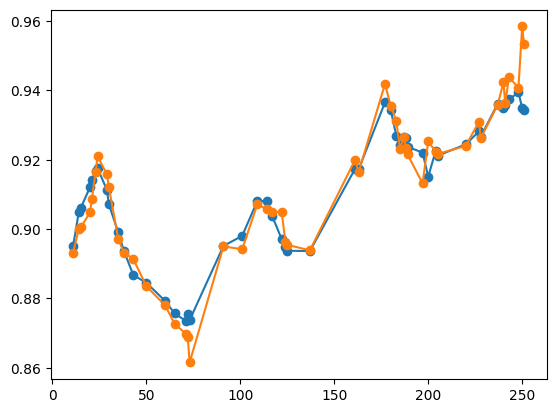

In [33]:
import matplotlib.pyplot as plt
plt.plot(df_test_pred_d1, marker='o')
plt.plot(df_test['Close_Day_1'], marker='o')

In [34]:
df_test_pred_d2 = pd.DataFrame(Y_test_pred[:,1], Y_test.index)

In [35]:
df_test_pred_d2 = df_test_pred_d2.sort_index()

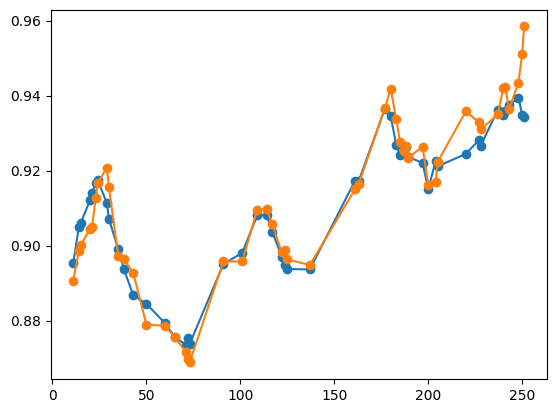

In [36]:
import matplotlib.pyplot as plt
plt.plot(df_test_pred_d1, marker='o')
plt.plot(df_test['Close_Day_2'], marker='o')

# Predict next 5 days

In [37]:
feats

,Date,opt_sine_offset,opt_sine_amp,opt_sine_freq,opt_sine_phase,opt_fourier_offset,opt_fourier_cosamp,opt_fourier_cosfreq,opt_fourier_cosphase,opt_fourier_sinamp,...,ROC1,ROC5,ROC20,WILLIAMS14,RSI14,CMO9,DEMA9,TEMA9,STOCH14,Close
0,2023-11-04,0.904953,1.000000,1.000124,0.000366,0.905610,0.215978,1.072017,-4.397565,-0.215485,...,84.982082,34.598417,151.006874,-4255.357016,45.974653,-12.086767,-0.013364,-0.012377,45.974653,0.89770
1,2023-11-03,0.904123,1.000000,1.000192,-0.003185,0.905757,-0.002462,0.847445,-0.969690,0.002326,...,-5.271008,-42.379707,191.195203,-4216.877859,55.677407,14.462076,-0.011106,-0.008642,55.677407,0.90610
2,2023-11-02,0.901706,1.000000,1.000731,-0.003333,0.905607,-0.141231,0.843288,0.835033,-0.141714,...,68.720892,-45.891929,-1768.006304,-4219.397328,55.101292,12.912282,-0.012225,-0.009451,55.101292,0.90555
3,2023-11-01,0.898767,1.000000,1.000392,-0.003243,0.905264,-0.072246,1.006131,0.495066,-0.072345,...,-55.585732,-73.022514,-224.046896,-4199.928706,60.769001,29.190840,-0.013553,-0.010532,60.769001,0.90980
4,2023-10-31,0.896256,1.018195,1.000557,-0.003197,0.904894,0.177432,1.264659,0.372684,0.177539,...,2.502864,-45.145772,-826.910775,-4364.310045,52.507979,7.281077,-0.017558,-0.015624,52.507979,0.90206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,2022-11-10,0.997987,1.000000,0.999582,-0.000539,0.995963,-0.608212,0.969817,0.830693,-0.609766,...,-1.387559,-22.658654,-17.062716,-1963.214006,42.364945,-21.601325,0.073269,0.069938,42.364945,0.98350
258,2022-11-09,1.000338,0.992253,0.999516,0.003374,0.996538,-0.852158,0.961759,3.766179,-0.851395,...,-6.077187,-18.216446,-16.112123,-2762.815873,42.969276,-20.200113,0.077081,0.074358,42.969276,0.98445
259,2022-11-08,1.003518,1.002636,0.999268,0.001566,0.996713,-0.004760,1.069634,-1.830722,-0.004564,...,-9.733076,-14.667741,-12.726643,-3033.283210,45.798136,-13.728942,0.081971,0.080726,45.798136,0.98888
260,2022-11-07,1.002761,1.395380,1.000733,-0.004310,0.996701,-0.138699,1.065864,-2.274728,0.138444,...,-17.119006,0.410317,2.774399,-3053.201820,51.369951,-0.895766,0.086552,0.087274,51.369951,0.99674


In [38]:
def prepare_for_pred(df: pd.DataFrame, n_lag_features: int = 10):
    df = df.copy()
    df.drop(['t'], axis=1)
    X = []
    
    for col in df.columns:
        if col == 'Date':
            X.append(df[col])
        elif col != 'Close':
            col_lag_features = pd.DataFrame()
            for i in range(n_lag_features):
                lag_feature_name = f'{col}_Lag_{i}'
                col_lag_features[lag_feature_name] = df[col].shift(-i)
            X.append(col_lag_features)
        
    df = pd.concat(X, axis=1)
    df.dropna(inplace=True)
    return df


In [39]:
input_feats = prepare_for_pred(feats, n_lag_features).iloc[[0]]
input_feats

,Date,opt_sine_offset_Lag_0,opt_sine_offset_Lag_1,opt_sine_offset_Lag_2,opt_sine_offset_Lag_3,opt_sine_offset_Lag_4,opt_sine_offset_Lag_5,opt_sine_offset_Lag_6,opt_sine_offset_Lag_7,opt_sine_offset_Lag_8,...,STOCH14_Lag_0,STOCH14_Lag_1,STOCH14_Lag_2,STOCH14_Lag_3,STOCH14_Lag_4,STOCH14_Lag_5,STOCH14_Lag_6,STOCH14_Lag_7,STOCH14_Lag_8,STOCH14_Lag_9
0,2023-11-04,0.904953,0.904123,0.901706,0.898767,0.896256,0.89434,0.89308,0.893069,0.895026,...,45.974653,55.677407,55.101292,60.769001,52.507979,52.962893,48.623017,45.855315,40.794126,37.104654


In [40]:
input_feats = input_feats.drop(columns=['Date'])
input_feats

,opt_sine_offset_Lag_0,opt_sine_offset_Lag_1,opt_sine_offset_Lag_2,opt_sine_offset_Lag_3,opt_sine_offset_Lag_4,opt_sine_offset_Lag_5,opt_sine_offset_Lag_6,opt_sine_offset_Lag_7,opt_sine_offset_Lag_8,opt_sine_offset_Lag_9,...,STOCH14_Lag_0,STOCH14_Lag_1,STOCH14_Lag_2,STOCH14_Lag_3,STOCH14_Lag_4,STOCH14_Lag_5,STOCH14_Lag_6,STOCH14_Lag_7,STOCH14_Lag_8,STOCH14_Lag_9
0,0.904953,0.904123,0.901706,0.898767,0.896256,0.89434,0.89308,0.893069,0.895026,0.896682,...,45.974653,55.677407,55.101292,60.769001,52.507979,52.962893,48.623017,45.855315,40.794126,37.104654


In [41]:
input_feats_scaled = scaler.transform(input_feats)

In [42]:
input_feats_scaled_reduced = pca.transform(input_feats_scaled)

In [43]:
preds_scaled = pd.DataFrame()
for i in range(1, n_days_ahead + 1):
    preds_scaled[f'Close_Day_{i}'] = svrs[i-1].predict(input_feats_scaled_reduced)
preds_scaled

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
0,0.023465,0.009877,0.076592,0.131631,0.100079


In [44]:
preds_unscaled = scaler_y.inverse_transform(preds_scaled)

In [45]:
pd.DataFrame(preds_unscaled, columns=preds_scaled.columns)

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
0,0.906074,0.905388,0.906734,0.907563,0.906475


In [46]:
outfile = 'predictions_T_svr.csv'

# Save the NumPy matrix to the CSV file (append mode)
with open(outfile, 'a') as f:
    np.savetxt(f, preds_unscaled, delimiter=',')